Load necessary libraries and functions:

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy import linalg as LA
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

def convertNansToZeros(ma):
    nan_elements = np.flatnonzero(np.isnan(ma.data))
    if len(nan_elements) > 0:
        ma.data[nan_elements] = 0
    return ma


def convertInfsToZeros(ma):
    inf_elements = np.flatnonzero(np.isinf(ma.data))
    if len(inf_elements) > 0:
        ma.data[inf_elements] = 0
    return ma
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [ ]:
run = 'bc48'
gpseqdir = '/home/garner1/Work/dataset/gpseq+hic/gpseq.1M.bincount/'
hicdir = '/home/garner1/Work/dataset/gpseq+hic/'
partition = 'fixed_step_centrality'
karyotype = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,'X'] # chr9 and chr22 are missing 
for time in ['10min','15min','30min','on']:
    for centrality in range(1,11):
        print centrality, time
        for chr_i in karyotype:
            gpseq_i = gpseqdir+run+'/'+time+'/chr'+str(chr_i)
            datap_gpseq_i = np.loadtxt(gpseq_i,usecols=(0,1))
            i_gpseq = datap_gpseq_i[:,0].astype(int) #bin i in gpseq
            pi_gpseq = datap_gpseq_i[:,1].astype(int) #count in bin i
            rows_gpseq = int(max(i_gpseq)) 
            for chr_j in karyotype[karyotype.index(chr_i):]:
                gpseq_j = gpseqdir+run+'/'+time+'/chr'+str(chr_j)
                hic = hicdir+run+'/'+partition+'/chr'+str(chr_i)+'-chr'+str(chr_j)+'.1M.none.observed.txt.'+run+'.tsv'

                datap_gpseq_j = np.loadtxt(gpseq_j,usecols=(0,1)) 
                data_hic = np.loadtxt(hic,usecols=(0,1,2,3,4,5,6))

                i_hic = data_hic[:,0].astype(int) # bin labels as rows
                j_hic = data_hic[:,1].astype(int) # bin labels as cols
                pij_hic = data_hic[:,2].astype(int) # number of contact between i and j bins

                j_gpseq = datap_gpseq_j[:,0].astype(int) # bin j in gpseq
                pj_gpseq = datap_gpseq_j[:,1].astype(int) # count in bin j from gpseq

                rows_hic = int(max(i_hic))
                cols_hic = int(max(j_hic))
                cols_gpseq = int(max(j_gpseq))
                rows = max([rows_hic,rows_gpseq])
                cols = max([cols_hic,cols_gpseq])

                joint = coo_matrix((pij_hic, (i_hic, j_hic)), shape=(rows+1, cols+1)).todense()
                
                row_index = np.array(i_hic[data_hic[:,3] == centrality]) # filter mat by centralities
                col_index = np.array(j_hic[data_hic[:,5] == centrality]) # filter mat by centralities
                newjoint = np.zeros(joint.shape)
                for row in xrange(joint.shape[0]):
                    for col in xrange(joint.shape[1]):
                        if (row in row_index) and (col in col_index):
                            newjoint[row,col] = joint[row,col]
                if chr_i is chr_j: 
                    locals()['JOINTchrom'+str(chr_i)+'chrom'+str(chr_j)+'_layer'+str(centrality)] = newjoint+newjoint.transpose()
                if chr_i is not chr_j: 
                    locals()['JOINTchrom'+str(chr_i)+'chrom'+str(chr_j)+'_layer'+str(centrality)] = newjoint
                    locals()['JOINTchrom'+str(chr_j)+'chrom'+str(chr_i)+'_layer'+str(centrality)] = newjoint.transpose()
            locals()['MARGINALSchrom'+str(chr_i)+'_layer'+str(centrality)+'_'+str(time)] = coo_matrix((pi_gpseq, (i_gpseq, np.zeros(len(i_gpseq)))), shape=(rows+1, 1)).todense().ravel()    
    

In [13]:
'''Build the genome-wide matrix as a block matrix of chromosomes'''
for centrality in range(1,11):
    locals()['genome_'+str(centrality)] = np.block([[locals()['JOINTchrom'+str(i)+'chrom'+str(j)+'_layer'+str(centrality)] for j in karyotype] for i in karyotype])
    print centrality, locals()['genome_'+str(centrality)].sum()
    for time in ['10min','15min','30min','on']: 
        locals()['marginal_'+str(centrality)+str(time)] = np.block([locals()['MARGINALSchrom'+str(i)+'_layer'+str(centrality)+'_'+str(time)] for i in karyotype])

'''Take the total sum, over centralities, of the joint counts'''
genome = locals()['genome_'+str(1)]
for centrality in range(2,11):
    genome = genome + locals()['genome_'+str(centrality)]
norma = genome.sum() # total sum of contacts over all layers

'''Take the total sum of the marginal counts, depending on time'''
for time in ['10min','15min','30min','on']:  
    locals()['marginal_time'+str(time)] = locals()['marginal_'+str(1)+str(time)] # first layer
    for centrality in range(2,11):
        locals()['marginal_time'+str(time)] = locals()['marginal_time'+str(time)] + locals()['marginal_'+str(centrality)+str(time)]
    locals()['norma_time'+str(time)]= locals()['marginal_time'+str(time)].sum() # read count at a given time

1 64208282.0
2 272863722.0
3 263478990.0
4 180786014.0
5 92157788.0
6 20168380.0
7 6064138.0
8 1166860.0
9 0.0
10 588858.0


In [14]:
'''For each time and centrality layer evaluate the partial mutual information'''
for time in ['10min','15min','30min','on']:
    print time
    for centrality in range(1,11):
        joint = locals()['genome_'+str(centrality)]
        joint = joint*1.0/norma 
        marginal = locals()['marginal_'+str(centrality)+str(time)]
        marginal = marginal*1.0/locals()['norma_time'+str(time)]

        info = np.log2(joint*1.0/np.outer(marginal,marginal))
        info = convertNansToZeros(coo_matrix(info)).todense()
        info = convertInfsToZeros(coo_matrix(info)).todense()

        locals()['MI_layer'+str(centrality)+'_'+str(time)] = np.array(joint) * np.array(info)
        print locals()['MI_layer'+str(centrality)+'_'+str(time)].sum()

10min


/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


1.1623049541456723
4.9493264085965025
5.109251887426361
3.7638965866084173
2.0097459305663716
0.4612090924394927
0.14106561204501486
0.027939712366821357
0.0
0.014115854786786279
15min
1.1324088546281306
4.883591117848996
5.093379880921194
3.7437890869812613
2.0002475819129044
0.45540623938289504
0.14009916447499493
0.02732488449013851
0.0
0.013805580791784561
30min
1.1187014108985156
4.724064095067904
4.848761222677651
3.533430705769024
1.8709597373027427
0.4278500139124648
0.13249383572436566
0.02564182504392909
0.0
0.012945324260281856
on
1.1727997003561377
4.78626544816399
4.721759529337906
3.3209410716307515
1.7065300942545845
0.3836129094027981
0.11632662403332966
0.021954280017991643
0.0
0.01107081149178604


In [19]:
'''For each centrality layer evaluate the partial mutual information considering HiC only'''
marginal = np.sum(genome*1.0/genome.sum(), 1)
marginal = marginal*1.0/marginal.sum()
for centrality in range(1,11):
    joint = locals()['genome_'+str(centrality)]
    joint = joint*1.0/norma
    
    info = np.log2(joint*1.0/np.outer(marginal,marginal))
    info = convertNansToZeros(coo_matrix(info)).todense()
    info = convertInfsToZeros(coo_matrix(info)).todense()

    locals()['MI_layer'+str(centrality)] = np.array(joint) * np.array(info)
    locals()['control_layer'+str(centrality)] = joint.sum()
    print locals()['MI_layer'+str(centrality)].sum()

/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  


0.7528265440797477
2.723819681885798
2.6319202336734744
1.8213965170638438
0.9268275394203292
0.22673857698331903
0.0691999609340773
0.013693008543618523
0.0
0.006911072630944033


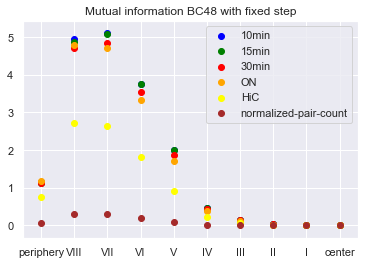

In [31]:
fig, ax = plt.subplots()

time = '10min'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='blue',label='10min')

time = '15min'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='green',label='15min')

time = '30min'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='red',label='30min')

time = 'on'
y = [locals()['MI_layer'+str(centrality)+'_'+str(time)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='orange',label='ON')

y = [locals()['MI_layer'+str(centrality)].sum() for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='yellow',label='HiC')

y = [locals()['control_layer'+str(centrality)] for centrality in range(1,11)]
ax.scatter(x=range(len(y)),y=y,color='brown',label='normalized-pair-count')

ax.set_xticks(range(0,10))
ax.set_xticklabels(["periphery","VIII","VII","VI","V","IV","III","II","I","center"])
ax.set_title('Mutual information BC48 with fixed step')
plt.legend()
plt.savefig('MI_BC48 with fixed step.png')
